# DIOMIRA-PYX

## A nb to develop the cython version of DIOMIRA

In [1]:
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%env IPYTHONDIR=/Users/jjgomezcadenas/Documents/Development/IPYTHON

env: IPYTHONDIR=/Users/jjgomezcadenas/Documents/Development/IPYTHON


In [3]:
%load_ext Cython

In [4]:
import pandas as pd
import numpy as np
import FEParam as FP
import tables
from time import time
from Util import *

In [14]:
%matplotlib inline

In [15]:
import matplotlib.pyplot as plt

In [69]:
from LogConfig import *
from Configure import configure
from Nh5 import *
import FEParam as FP
import SPE as SP
import FEE2 as FE
import tables
import wfmFunctions as wfm
import pandas as pd

## Cython demo

### Classical fib function

In [5]:
def fib(n):
    a,b = 0.0, 1.0
    for i in range(n):
        a,b = a+b,a
    return a

In [6]:
%%cython
def cfib(int n):
    cdef int i
    cdef double a = 0.0, b= 1.0
    for i in range(n):
        a,b = a+b, a
    return a

In [7]:
%timeit fib(0)

The slowest run took 8.84 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 351 ns per loop


In [8]:
%timeit fib(90)

100000 loops, best of 3: 6.02 µs per loop


In [9]:
%timeit cfib(0)

The slowest run took 24.58 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 48.5 ns per loop


In [10]:
%timeit cfib(90)

10000000 loops, best of 3: 119 ns per loop


In [11]:
f = 118./6050.

In [12]:
1./f

51.271186440677965

### A more realistic demo

### Rebin array

#### Python version

In [5]:
def rebin_pmt_array(a,stride):
    """
    rebins pmt array a according to stride
    there is a rebin_array in util which uses
    lenb = (len(a))/int(stride)
    this version uses (lean(a)+1) to correct from the fact that the
    MCRD is 599999 channels (should be 600000)
    """
    
    lenb = len(a)/int(stride)
    b = np.zeros(lenb)
    j=0
    for i in range(lenb):
        b[i] = np.sum(a[j:j+stride])
        j+= stride
    return b

In [19]:
cx = np.sin(np.arange(0.,np.pi/2.,0.001))

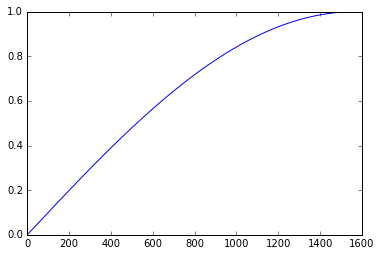

In [20]:
plt.plot(cx)

In [21]:
np.sum(cx)

999.70358986375845

In [22]:
%time y = rebin_pmt_array(cx,10)

CPU times: user 553 µs, sys: 87 µs, total: 640 µs
Wall time: 570 µs


In [23]:
%timeit y = rebin_pmt_array(cx,10)

1000 loops, best of 3: 384 µs per loop


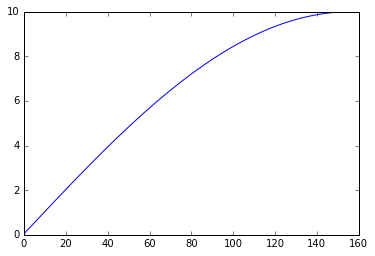

In [24]:
plt.plot(y)

In [25]:
np.sum(y)

998.70359018082661

#### Cython version (pure compilation)

In [26]:
%%cython
import numpy as np
def rebin_pmt_array_cy_v0(a,stride):
    """
    rebins pmt array a according to stride
    there is a rebin_array in util which uses
    lenb = (len(a))/int(stride)
    this version uses (lean(a)+1) to correct from the fact that the
    MCRD is 599999 channels (should be 600000)
    """
    
    lenb = len(a)/int(stride)
    b = np.zeros(lenb)
    j=0
    for i in range(lenb):
        b[i] = np.sum(a[j:j+stride])
        j+= stride
    return b

In [27]:
%timeit rebin_pmt_array_cy_v0(cx,10)

1000 loops, best of 3: 380 µs per loop


#### cython version 1

1. Declares variables
2. Uses memviews
3. Uses np.sum()

In [28]:
%%cython
import numpy as np
cimport numpy as np
def rebin_pmt_array_cy_v1(double [:] a,int stride):
    """
    rebins pmt array a according to stride
    there is a rebin_array in util which uses
    lenb = (len(a))/int(stride)
    this version uses (lean(a)+1) to correct from the fact that the
    MCRD is 599999 channels (should be 600000)
    """
    
    cdef:
        int lenb, i, j
        double [:] b
    
    lena =   a.shape[0]   
    lenb = a.shape[0]/stride
    
    b = np.zeros(lenb, dtype=np.double)
    
    j=0
    
    for i in range(lenb):
        b[i] = np.sum(a[j:j+stride])
        j+= stride
    
    
    return np.asarray(b)

In [30]:
%timeit y = rebin_pmt_array_cy_v1(cx,10)

1000 loops, best of 3: 996 µs per loop


*NB: v1 runs 3 time slower than v0 and pure python *

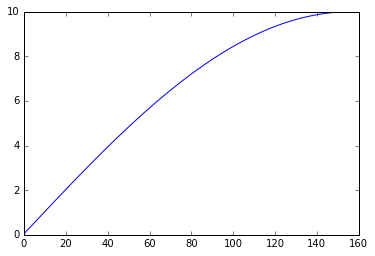

In [31]:
plt.plot(y)

In [32]:
np.sum(y)

998.70359018082661

#### cyton version 2 (cythonizes the sum)

In [33]:
%%cython
import numpy as np
cimport numpy as np
def rebin_pmt_array_cy_v2(double [:] a,int stride):
    """
    rebins pmt array a according to stride
    there is a rebin_array in util which uses
    lenb = (len(a))/int(stride)
    this version uses (lean(a)+1) to correct from the fact that the
    MCRD is 599999 channels (should be 600000)
    """
    
    cdef:
        int lenb, i, j,k
        double [:] b
        double part_sum
    
    lena =   a.shape[0]   
    lenb = a.shape[0]/stride
    
    b = np.zeros(lenb)
    
    j=0
    
    for i in range(lenb):
        part_sum = 0.
        for k in range(j, j + stride): 
            part_sum += a[k] 
        b[i] = part_sum
        j+= stride
    
    return np.asarray(b)

In [34]:
%timeit y = rebin_pmt_array_cy_v2(cx,10)

The slowest run took 13.18 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 6.22 µs per loop


* A very large IMPROVEMENT*

1. Pure Python: 384 mus
2. Cython v0: 30 mus
3. Cython v1: 996 mu
4. Cython v2: 6.22 mus

In [38]:
np.sum(y)

998.70359018082661

#### cyton version 3 (Direct use of nd.array() in function)

In [36]:
%%cython
import numpy as np
cimport numpy as np
def rebin_pmt_array_cy_v3(np.ndarray[np.float64_t, ndim=1] a,int stride):
    """
    rebins pmt array a according to stride
    there is a rebin_array in util which uses
    lenb = (len(a))/int(stride)
    this version uses (lean(a)+1) to correct from the fact that the
    MCRD is 599999 channels (should be 600000)
    """
    
    cdef:
        int lenb, i, j,k
        double part_sum
      
    lenb = a.shape[0]/stride
    cdef np.ndarray[np.float64_t, ndim=1] b = np.zeros(lenb) 
    
    j=0
    for i in range(lenb):
        part_sum = 0.
        for k in range(j, j + stride): 
            part_sum += a[k] 
        b[i] = part_sum
        j+= stride
    
    return b

In [37]:
%timeit y = rebin_pmt_array_cy_v3(cx,10)

The slowest run took 9.38 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 3.94 µs per loop


*Further improvement!*


1. Pure Python: 384 mus
2. Cython v0: 30 mus
3. Cython v1: 996 mu
4. Cython v2: 6.22 mus
5. Cython v3: 3.94 mus

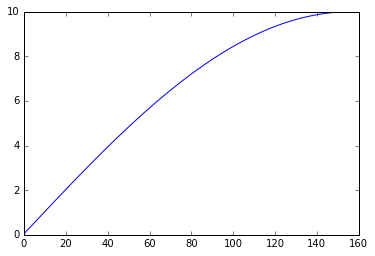

In [39]:
plt.plot(y)

#### cyton version 4 (switch off checks)

In [52]:
%%cython
import numpy as np
cimport numpy as np
from cython cimport boundscheck, wraparound
def rebin_pmt_array_cy_v4(np.ndarray[np.float64_t, ndim=1] a,int stride):
    """
    rebins pmt array a according to stride
    there is a rebin_array in util which uses
    lenb = (len(a))/int(stride)
    this version uses (lean(a)+1) to correct from the fact that the
    MCRD is 599999 channels (should be 600000)
    """
    
    cdef:
        int lenb, i, j,k
        double part_sum
      
    lenb = a.shape[0]/stride
    cdef np.ndarray[np.float64_t, ndim=1] b = np.zeros(lenb) 
    
    j=0
    with boundscheck(False), wraparound(False):
        for i in range(lenb):
            part_sum = 0.
            for k in range(j, j + stride): 
                part_sum += a[k] 
            b[i] = part_sum
            j+= stride
    
    return b

In [53]:
%timeit y = rebin_pmt_array_cy_v4(cx,10)

The slowest run took 12.54 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 3.12 µs per loop


*Further improvement!*


1. Pure Python: 384 mus
2. Cython v0: 30 mus
3. Cython v1: 996 mu
4. Cython v2: 6.22 mus
5. Cython v3: 3.94 mus
6. Cython v4: 3.12 mus

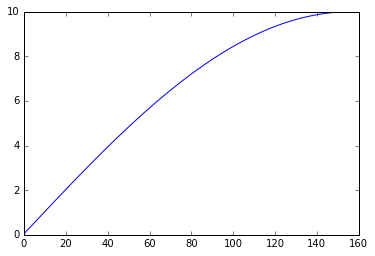

In [54]:
plt.plot(y)

#### cyton version 5 (as 4 but using memviews)

In [55]:
%%cython
import numpy as np
cimport numpy as np
from cython cimport boundscheck, wraparound
def rebin_pmt_array_cy_v5(double [:] a,int stride):
    """
    rebins pmt array a according to stride
    there is a rebin_array in util which uses
    lenb = (len(a))/int(stride)
    this version uses (lean(a)+1) to correct from the fact that the
    MCRD is 599999 channels (should be 600000)
    """
    
    cdef:
        int lenb, i, j,k
        double [:] b
        double part_sum
    
    lena =   a.shape[0]   
    lenb = a.shape[0]/stride
    
    b = np.zeros(lenb)
    
    j=0
    with boundscheck(False), wraparound(False):
        for i in range(lenb):
            part_sum = 0.
            for k in range(j, j + stride): 
                part_sum += a[k] 
            b[i] = part_sum
            j+= stride
    
    return np.asarray(b)

In [56]:
%timeit y = rebin_pmt_array_cy_v5(cx,10)

The slowest run took 10.50 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 5.7 µs per loop


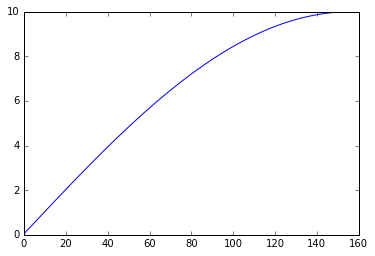

In [57]:
plt.plot(y)

1. Pure Python: 384 mus
2. Cython v0: 30 mus
3. Cython v1: 996 mu
4. Cython v2: 6.22 mus
5. Cython v3: 3.94 mus
6. Cython v4: 3.12 mus
6. Cython v5: 5.7 mus

*About a factor 15 improvement*

### Profiling

In [58]:
import cProfile

In [62]:
def main(code, version):
    cx = np.arange(0.,1000000., 1)
    if code =='py': 
        z = rebin_pmt_array(cx,10)
    else:
        z = eval('rebin_pmt_array_cy_'+version+'(cx,10)')

In [60]:
cProfile.run('main("py","v0")', sort='time')

         400005 function calls in 0.336 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   100000    0.149    0.000    0.149    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   100000    0.074    0.000    0.272    0.000 fromnumeric.py:1743(sum)
        1    0.059    0.059    0.331    0.331 {_cython_magic_439542c1297794ddb7ef37fe677858c0.rebin_pmt_array}
   100000    0.024    0.000    0.173    0.000 _methods.py:31(_sum)
   100000    0.024    0.000    0.024    0.000 {isinstance}
        1    0.005    0.005    0.005    0.005 {numpy.core.multiarray.arange}
        1    0.000    0.000    0.336    0.336 <ipython-input-59-c733d72f8be8>:1(main)
        1    0.000    0.000    0.336    0.336 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [63]:
cProfile.run('main("cy","v0")', sort='time')

         400006 function calls in 0.365 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   100000    0.163    0.000    0.163    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   100000    0.079    0.000    0.295    0.000 fromnumeric.py:1743(sum)
        1    0.065    0.065    0.360    0.360 {_cython_magic_bbf773f757df9c48c65bc65eeb9e15e4.rebin_pmt_array_cy_v0}
   100000    0.027    0.000    0.190    0.000 _methods.py:31(_sum)
   100000    0.026    0.000    0.026    0.000 {isinstance}
        1    0.005    0.005    0.005    0.005 {numpy.core.multiarray.arange}
        1    0.000    0.000    0.360    0.360 {eval}
        1    0.000    0.000    0.365    0.365 <ipython-input-62-a0d77e6e9a81>:1(main)
        1    0.000    0.000    0.360    0.360 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [64]:
cProfile.run('main("cy","v1")', sort='time')

         400008 function calls in 0.741 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   100000    0.314    0.000    0.314    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   100000    0.209    0.000    0.580    0.000 fromnumeric.py:1743(sum)
        1    0.160    0.160    0.740    0.740 {_cython_magic_dec29bf039b1b375fc2d32a0a3dcc815.rebin_pmt_array_cy_v1}
   100000    0.029    0.000    0.029    0.000 {isinstance}
   100000    0.028    0.000    0.342    0.000 _methods.py:31(_sum)
        1    0.001    0.001    0.001    0.001 {numpy.core.multiarray.arange}
        1    0.000    0.000    0.740    0.740 {eval}
        1    0.000    0.000    0.741    0.741 <ipython-input-62-a0d77e6e9a81>:1(main)
        1    0.000    0.000    0.740    0.740 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 numeric.py:414(asarray)
        1    0.000    0.000    0.000    0.000 {numpy.core.multiarray.array}
        1    0.00

In [65]:
cProfile.run('main("cy","v2")', sort='time')

         8 function calls in 0.003 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002    0.002    0.002 {_cython_magic_51566aa70cd45d37b878a7042a3a73ec.rebin_pmt_array_cy_v2}
        1    0.001    0.001    0.001    0.001 {numpy.core.multiarray.arange}
        1    0.000    0.000    0.002    0.002 {eval}
        1    0.000    0.000    0.003    0.003 <ipython-input-62-a0d77e6e9a81>:1(main)
        1    0.000    0.000    0.000    0.000 {numpy.core.multiarray.array}
        1    0.000    0.000    0.000    0.000 numeric.py:414(asarray)
        1    0.000    0.000    0.002    0.002 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [66]:
cProfile.run('main("cy","v3")', sort='time')

         6 function calls in 0.003 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002    0.002    0.002 {_cython_magic_c44ef359b8d114fae0bbcdb7d1513b4c.rebin_pmt_array_cy_v3}
        1    0.001    0.001    0.001    0.001 {numpy.core.multiarray.arange}
        1    0.000    0.000    0.002    0.002 {eval}
        1    0.000    0.000    0.003    0.003 <ipython-input-62-a0d77e6e9a81>:1(main)
        1    0.000    0.000    0.002    0.002 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [67]:
cProfile.run('main("cy","v4")', sort='time')

         6 function calls in 0.002 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.001    0.001 {_cython_magic_1e23bfee67652dff795868301472b730.rebin_pmt_array_cy_v4}
        1    0.001    0.001    0.001    0.001 {numpy.core.multiarray.arange}
        1    0.000    0.000    0.001    0.001 {eval}
        1    0.000    0.000    0.002    0.002 <ipython-input-62-a0d77e6e9a81>:1(main)
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [68]:
cProfile.run('main("cy","v5")', sort='time')

         8 function calls in 0.002 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.001    0.001 {_cython_magic_6fec0dae31ee12ba39a96217976aae5b.rebin_pmt_array_cy_v5}
        1    0.001    0.001    0.001    0.001 {numpy.core.multiarray.arange}
        1    0.000    0.000    0.001    0.001 {eval}
        1    0.000    0.000    0.002    0.002 <ipython-input-62-a0d77e6e9a81>:1(main)
        1    0.000    0.000    0.000    0.000 {numpy.core.multiarray.array}
        1    0.000    0.000    0.000    0.000 numeric.py:414(asarray)
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




*Thus the large improvement comes from replacing np.sum() which is efficient in python by a "Loop sum" which
appears to be more efficient in cython --> c (less overhead to python objects)

*NB It seems that the improvement for large arrays can be much larger***

## DIOMIRA

In [70]:
def FEE_param_table(fee_table):
    """
    Stores the parameters of the EP FEE simulation 
    """
    row = fee_table.row
    row['offset'] = FP.offset
    row['pmt_gain'] = FP.PMT_GAIN
    row['V_gain'] = FP.V_GAIN
    row['R'] = FP.R
    row['C12'] = FP.C12
    row['AC'] = FP.AC 
    row['time_step'] = FP.time_step
    row['time_daq'] = FP.time_DAQ
    row['freq_LPF'] = FP.freq_LPF
    row['freq_HPF'] = 1./(2*pi*FP.R*FP.C)
    row['LSB'] = FP.LSB
    row['volts_to_adc'] = FP.voltsToAdc/volt
    row['noise_fee_rms'] = FP.NOISE_FEE
    row['noise_adc'] = FP.NOISE_ADC
    
    row.append()

def wf2df(time_ns,energy_pes):
    """
    takes two vectors (time, energy) and returns a data frame representing a waveform
    """
    swf = {}
    swf['time_ns'] = time_ns
    swf['ene_pes'] = energy_pes 
    return pd.DataFrame(swf)

def store_twf(event, table, TWF):
    """
    Store TWF in table
    """
    row = table.row
    for ipmt in range(len(TWF)):
        twf = TWF[ipmt]
        for i in range(len(twf)):
            row['event'] = event
            row['pmt'] = ipmt
            row['time_ns'] = twf.time_ns[i]
            row['ene_pes'] = twf.ene_pes[i]
            row.append()
    table.flush()

def rebin_twf(t, e, stride = 40):
    """
    rebins the a waveform according to stride 
    The input waveform is a vector such that the index expresses time bin and the
    contents expresses energy (e.g, in pes)
    The function returns a DataFrame. The time bins and energy are rebinned according to stride
    """
    
    n = len(t)/int(stride)
    r = len(t)%int(stride)
    
    lenb = n
    if r > 0: 
        lenb = n+1
    
    T = np.zeros(lenb,dtype=np.float32)
    E = np.zeros(lenb,dtype=np.float32)
    
    j=0
    for i in range(n):
        E[i] = np.sum(e[j:j+stride])
        T[i] = np.mean(t[j:j+stride])
        j+= stride
        
    if r > 0:
        E[n] = np.sum(e[j:])
        T[n] = np.mean(t[j:])
    
    return T,E

def twf_signal(event_number,pmtrd, stride):
    """
    1) takes pmtrd
    2) Performs ZS
    3) Rebins resulting wf according to stride
    """
    
    rdata = []

    for j in range(pmtrd.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        energy_pes = pmtrd[event_number, j] #waveform for event event_number, PMT j
        time_ns = np.array(range(pmtrd.shape[2]))

        twf_zs = wfm.wf_thr(wf2df(time_ns,energy_pes),0.5)
        time_ns, ene_pes = rebin_twf(twf_zs.time_ns.values,twf_zs.ene_pes.values,stride)
        twf = wf2df(time_ns, ene_pes)
        
        logger.debug("-->len(twf) ={}".format(len(twf)))
        
        rdata.append(twf)
    return rdata

def simulate_sipm_response(event_number,sipmrd_):
    """
    For the moment use a dummy rutne that simply copies the sipm EARRAY
    """
    rdata = []

    for j in range(sipmrd_.shape[1]):
        rdata.append(sipmrd_[event_number, j])
    return np.array(rdata)


def simulate_pmt_response(event_number,pmtrd_):
    """
    Sensor Response
    Given a signal in PE (photoelectrons in bins of 1 ns) and the response function of 
    for a single photoelectron (spe) and front-end electronics (fee)
    this function produces the PMT raw data (adc counts bins 25 ns)

    pmtrd_ dataset that holds the PMT PE data for each PMT
    pmtrd25 dataset to be created with adc counts, bins 25 ns 
    after convoluting with electronics
    """
  
    rdata = []

    for j in range(pmtrd_.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        pmt = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        
        fee = FE.FEE(C=FP.C12[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN) 
        spe = SP.SPE(pmt_gain=FP.PMT_GAIN,x_slope = 5*ns,x_flat = 1*ns)
    
        signal_PMT = spe.SpePulseFromVectorPE(pmt) #PMT response

        #Front end response to PMT pulse (in volts)
        signal_fee = fee.FEESignal(signal_PMT, noise_rms=FP.NOISE_FEE) 

        #Signal out of DAQ
        #positive signal convention
        #signal_daq = fee.daqSignal(signal_fee, noise_rms=0) - FP.offset
        #negative signals convention!

        signal_daq = FP.offset -fee.daqSignal(signal_fee, noise_rms=0) 
    
        rdata.append(signal_daq)
    return np.array(rdata)


def DIOMIRA(argv):
    """
    Diomira driver
    """
    DEBUG_LEVEL, INFO, CYTHON, CFP = configure(argv[0],argv[1:])
   
    if INFO:
        
        print("""
        DIOMIRA:
         1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, 
        and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC


        """)
        FP.print_FEE()

    PATH_IN =CFP['PATH_IN']
    PATH_OUT =CFP['PATH_OUT']
    FILE_IN =CFP['FILE_IN']
    FILE_OUT =CFP['FILE_OUT']
    FIRST_EVT =CFP['FIRST_EVT']
    LAST_EVT =CFP['LAST_EVT']
    RUN_ALL =CFP['RUN_ALL']
    CLIB =CFP['CLIB']
    CLEVEL =CFP['CLEVEL']
    NEVENTS = LAST_EVT - FIRST_EVT

    print('Debug level = {}'.format(DEBUG_LEVEL))

    print("input path ={}; output path = {}; file_in ={} file_out ={}".format(
        PATH_IN,PATH_OUT,FILE_IN, FILE_OUT))

    print("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))

    print("Compression library = {} Compression level = {} ".format(
        CLIB,CLEVEL))

    # open the input file 
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN), "r+") as h5in: 
        # access the PMT raw data in file 

        pmtrd_ = h5in.root.pmtrd
        sipmrd_ = h5in.root.sipmrd

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)

        NPMT = pmtrd_.shape[1]
        NSIPM = sipmrd_.shape[1]
        PMTWL = pmtrd_.shape[2] 
        PMTWL_FEE = int((PMTWL+1)/FP.time_DAQ)
        #PMTWL_FEE = int(PMTWL/FP.time_DAQ)
        SIPMWL = sipmrd_.shape[2]
        NEVENTS_DST = pmtrd_.shape[0]

        print("nof PMTs = {} nof  SiPMs = {} nof events in input DST = {} ".format(
        NPMT,NSIPM,NEVENTS_DST))

        print("lof SiPM WF = {} lof PMT WF (MC) = {} lof PMT WF (FEE) = {}".format(
        PMTWL,SIPMWL,PMTWL_FEE))


        #access the geometry and the sensors metadata info

        geom_t = h5in.root.Detector.DetectorGeometry
        pmt_t = h5in.root.Sensors.DataPMT
        sipm_t = h5in.root.Sensors.DataSiPM
        mctrk_t = h5in.root.MC.MCTracks

        
        # open the output file 
        with tables.open_file("{}/{}".format(PATH_OUT,FILE_OUT), "w",
            filters=tables.Filters(complib=CLIB, complevel=CLEVEL)) as h5out:
 
            # create a group to store MC data
            mcgroup = h5out.create_group(h5out.root, "MC")
            # copy the mctrk table
            mctrk_t.copy(newparent=mcgroup)

            # create a group  to store geom data
            detgroup = h5out.create_group(h5out.root, "Detector")
            # copy the geom table
            geom_t.copy(newparent=detgroup)

            # create a group  store sensor data
            sgroup = h5out.create_group(h5out.root, "Sensors")
            # copy the pmt table
            pmt_t.copy(newparent=sgroup)
            # copy the sipm table
            sipm_t.copy(newparent=sgroup)

            # create a table to store Energy plane FEE data and hang it from MC group
            fee_table = h5out.create_table(mcgroup, "FEE", FEE,
                          "EP-FEE parameters",tables.Filters(0))
            
            
            # create a group to store True waveform data
            twfgroup = h5out.create_group(h5out.root, "TWF")
                                          
            # create a table to store true waveform (zs, rebinned)
            twf_table = h5out.create_table(twfgroup, "TWF", TWF, "Store for TWF",
                                tables.Filters(complib=CLIB, complevel=CLEVEL))

            # fill FEE table
            FEE_param_table(fee_table)

            # create a group to store RawData
            rgroup = h5out.create_group(h5out.root, "RD")
            
            # create an extensible array to store the RWF waveforms
            pmtrwf = h5out.create_earray(h5out.root.RD, "pmtrwf", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT, PMTWL_FEE), 
                                    expectedrows=NEVENTS_DST)
            
            # 29.9 tWF now stored in a table---
            # create an extensible array to store the TWF waveforms
#             pmttwf = h5out.create_earray(h5out.root.RD, "pmttwf", 
#                                     atom=tables.Float32Atom(), 
#                                     shape=(0, NPMT, PMTWL_FEE), 
#                                     expectedrows=NEVENTS_DST)
            

            sipmrwf = h5out.create_earray(h5out.root.RD, "sipmrwf", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NSIPM, SIPMWL), 
                                    expectedrows=NEVENTS_DST)

          
            if NEVENTS > NEVENTS_DST and RUN_ALL == False:
                print("""
                Refusing to run: you have requested
                FIRST_EVT = {}
                LAST_EVT  = {}
                Thus you want to run over {} events
                but the size of the DST is {} events.
                Please change your choice or select RUN_ALL = TRUE
                to run over the whole DST when this happens
                """.format(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST))
                sys.exit(0)
            elif  NEVENTS > NEVENTS_DST and RUN_ALL == True:
                FIRST_EVT = 0
                LAST_EVT = NEVENTS_DST
                NEVENTS = NEVENTS_DST


            for i in range(FIRST_EVT,LAST_EVT):
                logger.info("-->event number ={}".format(i))
                
                #truePMT = rebin_signal(i,pmtrd_, int(FP.time_DAQ))

                rebin = int(1*mus/1*ns)  #rebins zs function in 1 mus bin

                #list with zs twf
                truePMT = twf_signal(i,pmtrd_, rebin)
                
                #store in table
                store_twf(i, twf_table, truePMT)
                
                #truePMT.astype(float)

                #simulate PMT response and return an array with RWF
                dataPMT = simulate_pmt_response(i,pmtrd_)

                #convert to float
                dataPMT.astype(float) 
            
                
                #logger.info("truePMT shape ={}".format(truePMT.shape))
                #logger.info("dataPMT shape ={}".format(dataPMT.shape))
                
                #RWF for pmts
                pmtrwf.append(dataPMT.reshape(1, NPMT, PMTWL_FEE))
                
                
                #TWF for pmts
                #pmttwf.append(truePMT.reshape(1, NPMT, PMTWL_FEE))
                #pmtrd.append(dataPMT.reshape(1, NPMT, PMTWL))
                   
                #simulate SiPM response and return an array with new WF
                dataSiPM = simulate_sipm_response(i,sipmrd_)
                dataSiPM.astype(float)
                
                #append to SiPM EARRAY
                sipmrwf.append(dataSiPM.reshape(1, NSIPM, SIPMWL))

            pmtrwf.flush()
            sipmrwf.flush()


    print("Leaving Diomira. Safe travels!")


In [71]:
%less ../../Config/DIOMIRA_NA_ZLIB_test.csv

### Profile DIOMIRA

In [72]:
cProfile.run("DIOMIRA(['DIOMIRA','-d','INFO','-c','../../Config/DIOMIRA_NA_ZLIB_test.csv'])", sort='time')

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/; output path = /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5 file_out =Kr_ACTIVE_5bar_test10.h5
first event = 0 last event = 10 nof events requested = 10 
Compression library = zlib Compression level = 1 
nof PMTs = 12 nof  SiPMs = 1789 nof events in input DST = 1000 
lof SiPM WF = 1200000 lof PMT WF (MC) = 1200 lof PMT WF (FEE) = 48000
INFO:root:-->event number =0


-->event number =0


INFO:root:-->event number =1


-->event number =1


INFO:root:-->event number =2


-->event number =2


INFO:root:-->event number =3


-->event number =3


INFO:root:-->event number =4


-->event number =4


INFO:root:-->event number =5


-->event number =5


INFO:root:-->event number =6


-->event number =6


INFO:root:-->event number =7


-->event number =7


INFO:root:-->event number =8


-->event number =8


INFO:root:-->event number =9


-->event number =9


Leaving Diomira. Safe travels!
         972339 function calls (968589 primitive calls) in 28.915 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    23419    7.585    0.000    7.585    0.000 {numpy.core.multiarray.array}
      120    4.591    0.038    4.591    0.038 {method 'normal' of 'mtrand.RandomState' objects}
     1560    4.565    0.003    4.565    0.003 {numpy.core.multiarray.correlate}
      240    1.684    0.007    1.684    0.007 {scipy.signal.sigtools._linear_filter}
     2103    1.614    0.001    1.614    0.001 {range}
    18130    1.579    0.000    1.579    0.000 {method '_g_read_slice' of 'tables.hdf5extension.Array' objects}
       10    1.126    0.113   12.545    1.254 <ipython-input-70-0054900304c1>:77(twf_signal)
      120    0.775    0.006    7.059    0.059 FEE2.py:156(FEESignal)
       10    0.774    0.077   13.865    1.386 <ipython-input-70-0054900304c1>:112(simulate_pmt_response)
     2404    0.435    0

In [157]:
def DIOMIRA_cy(argv):
    """
    Diomira driver
    """
    DEBUG_LEVEL, INFO, CYTHON, CFP = configure(argv[0],argv[1:])
   
    if INFO:
        
        print("""
        DIOMIRA:
         1. Reads an MCRD file produced by art/centella, which stores MCRD 
         waveforms for PMTs (bins of 1 ns)
        and the SiPMs (bins of 1 mus)
            

        2. Simulates the response of the energy plane in the PMTs MCRD, 
        and produces both RWF and TWF:
        see: http://localhost:8931/notebooks/Nh5-Event-Model.ipynb#Reconstructed-Objects
        
            
        3. Simulates the response of the tracking plane in the SiPMs MCRD and outputs
            SiPM RWF (not yet implemented, for the time being simply copy the MCRD)

        4. Add a table describing the FEE parameters used for simulation

        5. Copies the tables on geometry, detector data and MC


        """)
        FP.print_FEE()

    PATH_IN =CFP['PATH_IN']
    PATH_OUT =CFP['PATH_OUT']
    FILE_IN =CFP['FILE_IN']
    FILE_OUT =CFP['FILE_OUT']
    FIRST_EVT =CFP['FIRST_EVT']
    LAST_EVT =CFP['LAST_EVT']
    RUN_ALL =CFP['RUN_ALL']
    CLIB =CFP['CLIB']
    CLEVEL =CFP['CLEVEL']
    NEVENTS = LAST_EVT - FIRST_EVT

    print('Debug level = {}'.format(DEBUG_LEVEL))

    print("input path ={}; output path = {}; file_in ={} file_out ={}".format(
        PATH_IN,PATH_OUT,FILE_IN, FILE_OUT))

    print("first event = {} last event = {} nof events requested = {} ".format(
        FIRST_EVT,LAST_EVT,NEVENTS))

    print("Compression library = {} Compression level = {} ".format(
        CLIB,CLEVEL))

    # open the input file 
    with tables.open_file("{}/{}".format(PATH_IN,FILE_IN), "r+") as h5in: 
        # access the PMT raw data in file 

        pmtrd_ = h5in.root.pmtrd
        sipmrd_ = h5in.root.sipmrd

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)

        NPMT = pmtrd_.shape[1]
        NSIPM = sipmrd_.shape[1]
        PMTWL = pmtrd_.shape[2] 
        PMTWL_FEE = int((PMTWL+1)/FP.time_DAQ)
        #PMTWL_FEE = int(PMTWL/FP.time_DAQ)
        SIPMWL = sipmrd_.shape[2]
        NEVENTS_DST = pmtrd_.shape[0]

        print("nof PMTs = {} nof  SiPMs = {} nof events in input DST = {} ".format(
        NPMT,NSIPM,NEVENTS_DST))

        print("lof SiPM WF = {} lof PMT WF (MC) = {} lof PMT WF (FEE) = {}".format(
        PMTWL,SIPMWL,PMTWL_FEE))


        #access the geometry and the sensors metadata info

        geom_t = h5in.root.Detector.DetectorGeometry
        pmt_t = h5in.root.Sensors.DataPMT
        sipm_t = h5in.root.Sensors.DataSiPM
        mctrk_t = h5in.root.MC.MCTracks

        
        # open the output file 
        with tables.open_file("{}/{}".format(PATH_OUT,FILE_OUT), "w",
            filters=tables.Filters(complib=CLIB, complevel=CLEVEL)) as h5out:
 
            # create a group to store MC data
            mcgroup = h5out.create_group(h5out.root, "MC")
            # copy the mctrk table
            mctrk_t.copy(newparent=mcgroup)

            # create a group  to store geom data
            detgroup = h5out.create_group(h5out.root, "Detector")
            # copy the geom table
            geom_t.copy(newparent=detgroup)

            # create a group  store sensor data
            sgroup = h5out.create_group(h5out.root, "Sensors")
            # copy the pmt table
            pmt_t.copy(newparent=sgroup)
            # copy the sipm table
            sipm_t.copy(newparent=sgroup)

            # create a table to store Energy plane FEE data and hang it from MC group
            fee_table = h5out.create_table(mcgroup, "FEE", FEE,
                          "EP-FEE parameters",tables.Filters(0))
            
            
            # create a group to store True waveform data
            twfgroup = h5out.create_group(h5out.root, "TWF")
                                          
            # create a table to store true waveform (zs, rebinned)
            twf_table = h5out.create_table(twfgroup, "TWF", TWF, "Store for TWF",
                                tables.Filters(complib=CLIB, complevel=CLEVEL))

            # fill FEE table
            FEE_param_table(fee_table)

            # create a group to store RawData
            rgroup = h5out.create_group(h5out.root, "RD")
            
            # create an extensible array to store the RWF waveforms
            pmtrwf = h5out.create_earray(h5out.root.RD, "pmtrwf", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NPMT, PMTWL_FEE), 
                                    expectedrows=NEVENTS_DST)
            
            # 29.9 tWF now stored in a table---
            # create an extensible array to store the TWF waveforms
#             pmttwf = h5out.create_earray(h5out.root.RD, "pmttwf", 
#                                     atom=tables.Float32Atom(), 
#                                     shape=(0, NPMT, PMTWL_FEE), 
#                                     expectedrows=NEVENTS_DST)
            

            sipmrwf = h5out.create_earray(h5out.root.RD, "sipmrwf", 
                                    atom=tables.Float32Atom(), 
                                    shape=(0, NSIPM, SIPMWL), 
                                    expectedrows=NEVENTS_DST)

          
            if NEVENTS > NEVENTS_DST and RUN_ALL == False:
                print("""
                Refusing to run: you have requested
                FIRST_EVT = {}
                LAST_EVT  = {}
                Thus you want to run over {} events
                but the size of the DST is {} events.
                Please change your choice or select RUN_ALL = TRUE
                to run over the whole DST when this happens
                """.format(FIRST_EVT,LAST_EVT,NEVENTS,NEVENTS_DST))
                sys.exit(0)
            elif  NEVENTS > NEVENTS_DST and RUN_ALL == True:
                FIRST_EVT = 0
                LAST_EVT = NEVENTS_DST
                NEVENTS = NEVENTS_DST


            for i in range(FIRST_EVT,LAST_EVT):
                logger.info("-->event number ={}".format(i))
                
                #truePMT = rebin_signal(i,pmtrd_, int(FP.time_DAQ))

                rebin = int(1*mus/1*ns)  #rebins zs function in 1 mus bin

                #list with zs twf
                truePMT = twf_signal_cy(i,pmtrd_, rebin)
                
                #store in table
                store_twf(i, twf_table, truePMT)
                
                #truePMT.astype(float)

                #simulate PMT response and return an array with RWF
                dataPMT = simulate_pmt_response_cy(i,pmtrd_)

                #convert to float
                dataPMT.astype(float) 
            
                
                #logger.info("truePMT shape ={}".format(truePMT.shape))
                #logger.info("dataPMT shape ={}".format(dataPMT.shape))
                
                #RWF for pmts
                pmtrwf.append(dataPMT.reshape(1, NPMT, PMTWL_FEE))
                
                
                #TWF for pmts
                #pmttwf.append(truePMT.reshape(1, NPMT, PMTWL_FEE))
                #pmtrd.append(dataPMT.reshape(1, NPMT, PMTWL))
                   
                #simulate SiPM response and return an array with new WF
                dataSiPM = simulate_sipm_response(i,sipmrd_)
                dataSiPM.astype(float)
                
                #append to SiPM EARRAY
                sipmrwf.append(dataSiPM.reshape(1, NSIPM, SIPMWL))

            pmtrwf.flush()
            sipmrwf.flush()


    print("Leaving Diomira. Safe travels!")



### Prototyping a cyton version for ZS and RB

#### Python version

In [145]:
def wfm_zs_and_rb_py(energy_pes, time_ns, stride):
    """
    python version:
    performs ZS and Rb
    """
    twf_zs = wfm.wf_thr(wf2df(time_ns,energy_pes),0.5)
    t_rb, ene_rb = rebin_twf(twf_zs.time_ns.values,twf_zs.ene_pes.values,stride)
    return ene_rb, t_rb
    

#### cython version

In [146]:
%%cython

import numpy as np
cimport numpy as np
from cython cimport boundscheck, wraparound

def wfm_zs_and_rb(np.ndarray[np.int32_t, ndim=1] energy_pes, np.ndarray[np.float32_t, ndim=1] time_ns, int stride):
    
    cdef int i, j, k, dim_rb, dim_zs, e_sum, r, n
           
    
    #ZS
    dim_zs = 0
    with boundscheck(False), wraparound(False):
        for k in range(len(energy_pes)):
            if energy_pes[k] > 0:
                dim_zs+=1
            
    cdef np.ndarray[np.int32_t, ndim=1] ene_zs = np.zeros(dim_zs, dtype=np.int32)
    cdef np.ndarray[np.float32_t, ndim=1] t_zs = np.zeros(dim_zs, dtype=np.float32)
    
    #print('dim_zs = {}'.format(dim_zs))
    
    i = 0
    with boundscheck(False), wraparound(False):
        for k in range(len(energy_pes)):
            if energy_pes[k] > 0:
                ene_zs[i] = energy_pes[k]
                t_zs[i] = time_ns[k]
                i+=1
                
        
    #RB
    n = ene_zs.shape[0]/stride
    r = ene_zs.shape[0]%stride
    
    if r > 0: 
        dim_rb = n+1
    
    #print('n = {} r = {} dim_rb = {}'.format(n,r,dim_rb))
        
    cdef np.ndarray[np.int32_t, ndim=1] ene_rb = np.zeros(dim_rb, dtype=np.int32)
    cdef np.ndarray[np.float32_t, ndim=1] t_rb = np.zeros(dim_rb, dtype=np.float32)
        
    #resum bins
    j=0
    with boundscheck(False), wraparound(False):
        for i in range(n):
            e_sum = 0    
            for k in range(j, j + stride): 
                e_sum += ene_zs[k] 
            ene_rb[i] = e_sum
            t_rb[i] = (t_zs[j] + t_zs[j + stride])/2.
            j+= stride
    
        #print('j={}'.format(j))
            
        if r > 0:
            e_sum = 0    
            for k in range(j, dim_zs): 
                e_sum += ene_zs[k] 
                
        ene_rb[n] = e_sum
        t_rb[n]  = (t_zs[j] + t_zs[dim_zs-1])/2. 
    
    #print(ene_rb)
    #print(t_rb)
            
    return ene_rb, t_rb
        

#### Check wfm_zs_and_rb

In [94]:
wfm_dim = 10000
stride = int(100)
time_ns = np.arange(0,wfm_dim,1, dtype = np.float32)
ene_pes = np.zeros(wfm_dim, dtype=np.int32)
po = np.random.poisson(1, 10000)
ene_pes[:] = po
print(ene_pes.dtype, time_ns.dtype, type(stride))

int32 float32 <type 'int'>


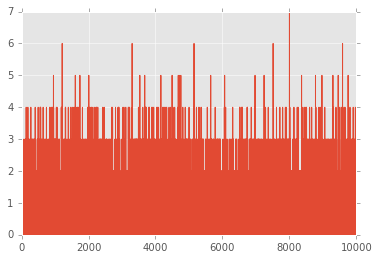

In [92]:
plt.plot(time_ns,ene_pes)

In [137]:
ene_rb, t_rb = wfm_zs_and_rb(ene_pes, time_ns, int(100))

dim_zs = 6367
n = 63 r = 67 dim_rb = 64
j=6300
[169 163 166 159 161 168 154 172 160 163 160 160 153 156 169 160 154 168
 163 166 155 151 168 152 162 170 161 159 159 165 168 153 168 154 167 150
 163 149 159 151 160 149 156 167 169 166 172 159 169 150 157 165 165 153
 162 160 156 158 156 147 152 156 171 106]
[   80.    242.    403.5   564.5   728.5   902.   1070.   1220.   1364.
  1514.   1675.   1840.5  2002.   2163.   2329.5  2501.   2660.   2812.
  2970.5  3131.5  3299.5  3464.   3619.   3766.   3923.   4093.5  4255.5
  4405.   4555.5  4701.   4852.   5014.   5171.5  5326.   5477.5  5635.
  5798.5  5959.5  6112.5  6263.5  6413.   6569.5  6732.5  6888.5  7037.
  7183.   7327.   7477.   7637.5  7795.5  7948.5  8095.5  8245.5  8399.
  8552.   8700.5  8854.   9014.5  9176.   9331.5  9482.5  9639.5  9804.5
  9945. ]


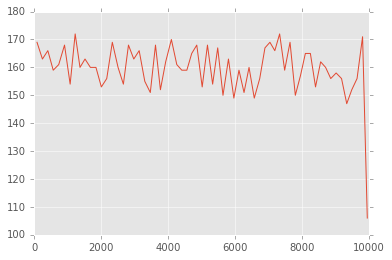

In [138]:
plt.plot(t_rb,ene_rb)

In [139]:
np.sum(ene_pes)

10209

In [140]:
np.sum(ene_rb)

10209

In [143]:
%timeit ene_rb, t_rb = wfm_zs_and_rb(ene_pes, time_ns, int(100))

10000 loops, best of 3: 67.1 µs per loop


In [147]:
ene_rb2, t_rb2 =wfm_zs_and_rb_py(ene_pes, time_ns, int(100))

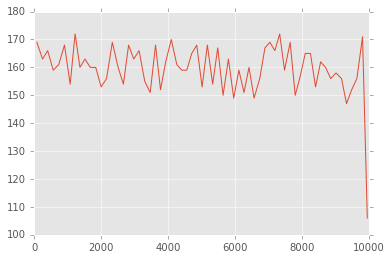

In [148]:
plt.plot(t_rb2,ene_rb2)

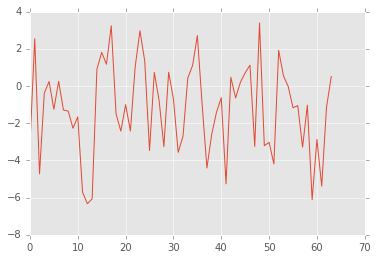

In [149]:
plt.plot(t_rb2 - t_rb)

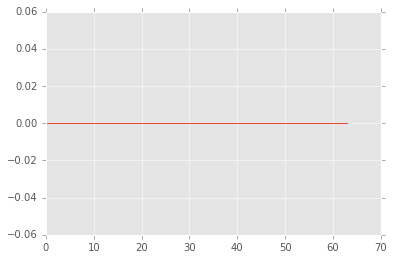

In [150]:
plt.plot(ene_rb2 - ene_rb)

In [151]:
np.sum(ene_rb2)

10209.0

In [152]:
%timeit ene_rb2, t_rb2 =wfm_zs_and_rb_py(ene_pes, time_ns, int(100))

100 loops, best of 3: 1.89 ms per loop


#### Cython version runs much faster
1. python: 1890 mus per loop
2. cython 67 mus per loop


In [153]:
factor = 1890./67

In [154]:
factor

28.208955223880597

### Now try a version of twf_signal that cythonizes the zs and rb 

In [156]:
def twf_signal_py2cy(event_number,pmtrd, stride):
    """
    py2cy --> python calls cython
    1) takes pmtrd
    2) Performs ZS
    3) Rebins resulting wf according to stride
    """
    
    rdata = []

    for j in range(pmtrd.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        energy_pes = np.zeros(pmtrd.shape[2], dtype=np.int32)
        energy_pes[:] = pmtrd[event_number, j]
        time_ns = np.array(range(pmtrd.shape[2]), dtype=np.float32)
        
        ene_rb, t_rb = wfm_zs_and_rb(energy_pes, time_ns, int(stride))
        twf = wf2df(t_rb, ene_rb)
        
        rdata.append(twf)
    return rdata

In [159]:
DIOMIRA_cy(['DIOMIRA','-d','INFO','-c','../../Config/DIOMIRA_NA_ZLIB_test.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/; output path = /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5 file_out =Kr_ACTIVE_5bar_test10.h5
first event = 0 last event = 10 nof events requested = 10 
Compression library = zlib Compression level = 1 
nof PMTs = 12 nof  SiPMs = 1789 nof events in input DST = 1000 
lof SiPM WF = 1200000 lof PMT WF (MC) = 1200 lof PMT WF (FEE) = 48000
INFO:root:-->event number =0


-->event number =0


INFO:root:-->event number =1


-->event number =1


INFO:root:-->event number =2


-->event number =2


INFO:root:-->event number =3


-->event number =3


INFO:root:-->event number =4


-->event number =4


INFO:root:-->event number =5


-->event number =5


INFO:root:-->event number =6


-->event number =6


INFO:root:-->event number =7


-->event number =7


INFO:root:-->event number =8


-->event number =8


INFO:root:-->event number =9


-->event number =9


Leaving Diomira. Safe travels!


In [160]:
cProfile.run("DIOMIRA_cy(['DIOMIRA','-d','INFO','-c','../../Config/DIOMIRA_NA_ZLIB_test.csv'])", sort='time')

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/; output path = /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5 file_out =Kr_ACTIVE_5bar_test10.h5
first event = 0 last event = 10 nof events requested = 10 
Compression library = zlib Compression level = 1 
nof PMTs = 12 nof  SiPMs = 1789 nof events in input DST = 1000 
lof SiPM WF = 1200000 lof PMT WF (MC) = 1200 lof PMT WF (FEE) = 48000
INFO:root:-->event number =0


-->event number =0


INFO:root:-->event number =1


-->event number =1


INFO:root:-->event number =2


-->event number =2


INFO:root:-->event number =3


-->event number =3


INFO:root:-->event number =4


-->event number =4


INFO:root:-->event number =5


-->event number =5


INFO:root:-->event number =6


-->event number =6


INFO:root:-->event number =7


-->event number =7


INFO:root:-->event number =8


-->event number =8


INFO:root:-->event number =9


-->event number =9


Leaving Diomira. Safe travels!
         838158 function calls (836928 primitive calls) in 24.960 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    22099    5.140    0.000    5.140    0.000 {numpy.core.multiarray.array}
      120    4.580    0.038    4.580    0.038 {method 'normal' of 'mtrand.RandomState' objects}
     1560    4.516    0.003    4.516    0.003 {numpy.core.multiarray.correlate}
      240    1.668    0.007    1.668    0.007 {scipy.signal.sigtools._linear_filter}
     1863    1.545    0.001    1.545    0.001 {range}
    18130    1.312    0.000    1.312    0.000 {method '_g_read_slice' of 'tables.hdf5extension.Array' objects}
       10    1.287    0.129    8.874    0.887 <ipython-input-156-0447d7915525>:1(twf_signal_py2cy)
       10    0.798    0.080   13.843    1.384 <ipython-input-70-0054900304c1>:112(simulate_pmt_response)
      120    0.773    0.006    7.033    0.059 FEE2.py:156(FEESignal)
       22    0.38

#### Diomira (python only)

#### Diomira_cy (cython inner loop)

### Profile!

In [161]:
def twf_signal_py(event_number,pmtrd, stride):
    """
    py2cy --> python calls cython
    1) takes pmtrd
    2) Performs ZS
    3) Rebins resulting wf according to stride
    """
    
    rdata = []

    for j in range(pmtrd.shape[1]):
        logger.debug("-->PMT number ={}".format(j))
                
        energy_pes = np.zeros(pmtrd.shape[2], dtype=np.int32)
        energy_pes[:] = pmtrd[event_number, j]
        time_ns = np.array(range(pmtrd.shape[2]), dtype=np.float32)
        
        ene_rb, t_rb = wfm_zs_and_rb(energy_pes, time_ns, int(stride))
        twf = wf2df(t_rb, ene_rb)
        
        rdata.append(twf)
    return rdata

In [162]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5')

In [163]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/test/nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(1000, 12, 1200000), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/sipmrd (EArray(1000, 1789, 1200), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 1200)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/MCT

In [164]:
pmtrd = h5f.root.pmtrd

In [166]:
rdata = twf_signal_py(0,pmtrd, 1000)

In [168]:
type(rdata)

list

In [169]:
cProfile.run("twf_signal_py(0,pmtrd, 1000)", sort='time')

         6256 function calls (6184 primitive calls) in 0.899 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      120    0.494    0.004    0.494    0.004 {numpy.core.multiarray.array}
       13    0.179    0.014    0.179    0.014 {range}
        1    0.129    0.129    0.897    0.897 <ipython-input-161-9e160c8802a8>:1(twf_signal_py)
       12    0.054    0.005    0.054    0.005 {method '_g_read_slice' of 'tables.hdf5extension.Array' objects}
       12    0.026    0.002    0.026    0.002 {_cython_magic_265197373be86ab28dfab2116c3624fc.wfm_zs_and_rb}
       24    0.004    0.000    0.004    0.000 {numpy.core.multiarray.zeros}
        1    0.001    0.001    0.899    0.899 <string>:1(<module>)
    36/24    0.001    0.000    0.003    0.000 base.py:124(__new__)
       96    0.001    0.000    0.001    0.000 {numpy.core.multiarray.empty}
     1296    0.001    0.000    0.001    0.000 {isinstance}
       12    0.001    0.000    0.001 

In [170]:
%timeit twf_signal_py(0,pmtrd, 1000)

1 loop, best of 3: 858 ms per loop


In [171]:
%timeit twf_signal(0,pmtrd, 1000)

1 loop, best of 3: 1.13 s per loop


In [189]:
%%cython

import numpy as np
cimport numpy as np
import pandas as pd

from cython cimport boundscheck, wraparound

def wf2df(time_ns,energy_pes):
    """
    takes two vectors (time, energy) and returns a data frame representing a waveform
    """
    swf = {}
    swf['time_ns'] = time_ns
    swf['ene_pes'] = energy_pes 
    return pd.DataFrame(swf)

def wfm_zs_and_rb(np.ndarray[np.int32_t, ndim=1] energy_pes, np.ndarray[np.float32_t, ndim=1] time_ns, int stride):
    
    cdef int i, j, k, dim_rb, dim_zs, e_sum, r, n
           
    
    #ZS
    dim_zs = 0
    with boundscheck(False), wraparound(False):
        for k in range(len(energy_pes)):
            if energy_pes[k] > 0:
                dim_zs+=1
            
    cdef np.ndarray[np.int32_t, ndim=1] ene_zs = np.zeros(dim_zs, dtype=np.int32)
    cdef np.ndarray[np.float32_t, ndim=1] t_zs = np.zeros(dim_zs, dtype=np.float32)
    
    #print('dim_zs = {}'.format(dim_zs))
    
    i = 0
    with boundscheck(False), wraparound(False):
        for k in range(len(energy_pes)):
            if energy_pes[k] > 0:
                ene_zs[i] = energy_pes[k]
                t_zs[i] = time_ns[k]
                i+=1
                
        
    #RB
    n = ene_zs.shape[0]/stride
    r = ene_zs.shape[0]%stride
    
    if r > 0: 
        dim_rb = n+1
    
    #print('n = {} r = {} dim_rb = {}'.format(n,r,dim_rb))
        
    cdef np.ndarray[np.int32_t, ndim=1] ene_rb = np.zeros(dim_rb, dtype=np.int32)
    cdef np.ndarray[np.float32_t, ndim=1] t_rb = np.zeros(dim_rb, dtype=np.float32)
        
    #resum bins
    j=0
    with boundscheck(False), wraparound(False):
        for i in range(n):
            e_sum = 0    
            for k in range(j, j + stride): 
                e_sum += ene_zs[k] 
            ene_rb[i] = e_sum
            t_rb[i] = (t_zs[j] + t_zs[j + stride])/2.
            j+= stride
    
        #print('j={}'.format(j))
            
        if r > 0:
            e_sum = 0    
            for k in range(j, dim_zs): 
                e_sum += ene_zs[k] 
                
        ene_rb[n] = e_sum
        t_rb[n]  = (t_zs[j] + t_zs[dim_zs-1])/2. 
    
    #print(ene_rb)
    #print(t_rb)
            
    return ene_rb, t_rb

def twf_signal_cy(int event_number,pmtrd, int stride):
    """
    py2cy --> python calls cython
    1) takes pmtrd
    2) Performs ZS
    3) Rebins resulting wf according to stride
    """
    
    rdata = np.empty(pmtrd.shape[1], dtype=object)
    cdef int j
    
    for j in range(pmtrd.shape[1]):
                
        energy_pes = np.zeros(pmtrd.shape[2], dtype=np.int32)
        energy_pes[:] = pmtrd[event_number, j]
        time_ns = np.array(range(pmtrd.shape[2]), dtype=np.float32)
        
        ene_rb, t_rb = wfm_zs_and_rb(energy_pes, time_ns, int(stride))
        twf = wf2df(t_rb, ene_rb)
        
        rdata[j] = twf
    return rdata

In [190]:
%timeit twf_signal_cy(0,pmtrd, 1000)

1 loop, best of 3: 865 ms per loop


In [185]:
cProfile.run("twf_signal_cy(0,pmtrd, 1000)", sort='time')

         6135 function calls (6063 primitive calls) in 0.897 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.835    0.835    0.897    0.897 {_cython_magic_c7a45a2770d7fe86978c43ba4d60db4a.twf_signal_cy}
       12    0.051    0.004    0.051    0.004 {method '_g_read_slice' of 'tables.hdf5extension.Array' objects}
       96    0.002    0.000    0.002    0.000 {numpy.core.multiarray.empty}
    36/24    0.001    0.000    0.003    0.000 base.py:124(__new__)
     1296    0.001    0.000    0.001    0.000 {isinstance}
       12    0.001    0.000    0.003    0.000 internals.py:4007(form_blocks)
       12    0.000    0.000    0.001    0.000 array.py:370(_interpret_indexing)
       24    0.000    0.000    0.001    0.000 numeric.py:607(require)
       12    0.000    0.000    0.001    0.000 internals.py:2674(_rebuild_blknos_and_blklocs)
       36    0.000    0.000    0.000    0.000 {pandas.lib.infer_dtype}
       36    0.

In [186]:
cProfile.run("twf_signal(0,pmtrd, 1000)", sort='time')

         19672 function calls (19348 primitive calls) in 1.266 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      252    0.761    0.003    0.761    0.003 {numpy.core.multiarray.array}
       37    0.151    0.004    0.151    0.004 {range}
        1    0.111    0.111    1.265    1.265 <ipython-input-70-0054900304c1>:77(twf_signal)
       12    0.073    0.006    0.073    0.006 {method '_g_read_slice' of 'tables.hdf5extension.Array' objects}
       96    0.052    0.001    0.052    0.001 {numpy.core.multiarray.arange}
       36    0.035    0.001    0.036    0.001 numeric.py:607(require)
       36    0.029    0.001    0.035    0.001 internals.py:4168(_stack_arrays)
       12    0.008    0.001    0.010    0.001 wfmFunctions.py:87(<lambda>)
      180    0.007    0.000    0.007    0.000 {numpy.core.multiarray.empty}
       12    0.003    0.000    0.003    0.000 {method 'nonzero' of 'numpy.ndarray' objects}
     3552    0.002    0

In [203]:
%%cython

import numpy as np
cimport numpy as np
import pandas as pd
import FEParam as FP
import SPE as SP
import FEE2 as FE

def simulate_pmt_response_cy(int event_number,pmtrd):
    """
    Sensor Response
    Given a signal in PE (photoelectrons in bins of 1 ns) and the response function of 
    for a single photoelectron (spe) and front-end electronics (fee)
    this function produces the PMT raw data (adc counts bins 25 ns)

    pmtrd_ dataset that holds the PMT PE data for each PMT
    pmtrd25 dataset to be created with adc counts, bins 25 ns 
    after convoluting with electronics
    """
  
    cdef float coulomb = 1./1.60217733e-19
    cdef float volt = 1.e-6
    cdef float mV = 1.e-3*volt
    cdef float second      = 1.e+9
    cdef float nF=1.e-9*coulomb/volt
    cdef float ampere = coulomb/second
    cdef float hertz = 1./second
    cdef float ns  = 1.
    
    cdef float ohm = volt/ampere
    
    C12 = np.array([ 6.02975448,  6.22547194, 6.0671337 ,  6.22159457,  6.29999787,
        6.09892384,  6.18289435,  6.21775591,  6.19306671,  6.30518792,
        6.20359891,  6.31231192])*nF
    
    cdef float R = 2350*ohm
    cdef float V_GAIN=250*ohm 
    cdef float freq_LPF=3e+6*hertz
    cdef float PMT_GAIN=4.5e6
    
    cdef NOISE_FEE = 0.7*mV
    cdef int offset = 2500

    rdata = np.empty(pmtrd.shape[1], dtype=object)
    cdef int j
    for j in range(pmtrd.shape[1]):
        pmt = np.zeros(pmtrd.shape[2], dtype=np.int32)
        pmt[:] = pmtrd[event_number, j]
        
        fee = FE.FEE(C=C12[j],R= R, f=freq_LPF, RG=V_GAIN) 
        spe = SP.SPE(pmt_gain=PMT_GAIN,x_slope = 5*ns,x_flat = 1*ns)
    
        signal_PMT = spe.SpePulseFromVectorPE(pmt) #PMT response

        #Front end response to PMT pulse (in volts)
        signal_fee = fee.FEESignal(signal_PMT, noise_rms=NOISE_FEE) 
        signal_daq = offset -fee.daqSignal(signal_fee, noise_rms=0) 
    
        rdata[j] = signal_daq
    return rdata

In [204]:
%timeit simulate_pmt_response(0,pmtrd)

1 loop, best of 3: 1.3 s per loop


In [205]:
%timeit simulate_pmt_response_cy(0,pmtrd)

1 loop, best of 3: 1.35 s per loop


In [207]:
cProfile.run("simulate_pmt_response(0,pmtrd)", sort='time')

         15269 function calls in 1.407 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       12    0.474    0.039    0.474    0.039 {method 'normal' of 'mtrand.RandomState' objects}
      156    0.458    0.003    0.458    0.003 {numpy.core.multiarray.correlate}
       24    0.168    0.007    0.168    0.007 {scipy.signal.sigtools._linear_filter}
       12    0.076    0.006    0.719    0.060 FEE2.py:156(FEESignal)
        1    0.072    0.072    1.402    1.402 <ipython-input-70-0054900304c1>:112(simulate_pmt_response)
       12    0.057    0.005    0.057    0.005 {method '_g_read_slice' of 'tables.hdf5extension.Array' objects}
       96    0.026    0.000    0.026    0.000 {numpy.core.multiarray.zeros}
       12    0.019    0.002    0.375    0.031 shape_base.py:20(apply_along_axis)
       36    0.014    0.000    0.558    0.016 signaltools.py:845(lfilter)
       12    0.010    0.001    0.403    0.034 FEE2.py:176(daqSignal)
    

In [208]:
cProfile.run("simulate_pmt_response_cy(0,pmtrd)", sort='time')

         15207 function calls in 1.385 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       12    0.461    0.038    0.461    0.038 {method 'normal' of 'mtrand.RandomState' objects}
      156    0.441    0.003    0.441    0.003 {numpy.core.multiarray.correlate}
       24    0.169    0.007    0.169    0.007 {scipy.signal.sigtools._linear_filter}
        1    0.095    0.095    1.381    1.381 {_cython_magic_da7c74cf5923dc35d77871964e4e344a.simulate_pmt_response_cy}
       12    0.078    0.006    0.709    0.059 FEE2.py:156(FEESignal)
       12    0.047    0.004    0.047    0.004 {method '_g_read_slice' of 'tables.hdf5extension.Array' objects}
       96    0.024    0.000    0.024    0.000 {numpy.core.multiarray.zeros}
       12    0.019    0.002    0.367    0.031 shape_base.py:20(apply_along_axis)
       36    0.014    0.000    0.550    0.015 signaltools.py:845(lfilter)
       12    0.010    0.001    0.395    0.033 FEE2.py:176(

####  No gain in simulate_pmt_response, already optimized using SciPy-based FEE functions. 

Cythonize twf_signal leads to a gain, but not spectacular: 25 vs 30 (20%)

In [209]:
30./25.

1.2

In [210]:
h5f.close()